# Example DNN code

## Library Import

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
#import lib.dataProcess as dp
from pandas import DataFrame as df

In [3]:
from tensorflow.python.keras.callbacks import TensorBoard
from time import time
from sklearn.model_selection import train_test_split
from keras import backend as K

Using TensorFlow backend.


In [4]:
def check_correct(predict, y): #get a prediction value and real value
    result = {}
    result['True-Positive'] = 0
    result['False-Negative'] = 0
    result['True-Negative'] = 0
    result['False-Positive'] = 0

    for i in range(len(predict)) :
        if int(y[i])==1 : # when the patient has resistant 
            if int(predict[i]) == 1 : # when the prediction is right
                result['True-Positive'] += 1
            else :                    # when the prediction is wrong
                result['False-Negative'] += 1
        else :           #when the patient has sensitive
            if int(predict[i]) == 0 : # when the prediction is right
                result['True-Negative'] += 1
            else :                    # when the prediction is wrong
                result['False-Positive'] += 1

    # calculate sensitivity
    sensitivity=result['True-Positive']/(result['True-Positive']+result['False-Negative'])
    
    # calculate specificity
    specificity=result['True-Negative']/(result['True-Negative']+result['False-Positive'])

    return sensitivity, specificity

In [5]:
def custom_loss(y_true, y_pred): #customized loss function 

    # calculate true positive
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # calculate true negative
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    # calculate false positive
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    # calculate false negative
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    sen=tp/(tp+fn+K.epsilon())
    spe=tn/(tn+fp+K.epsilon())
                                #K.epsilon()(very small positive number) is prevent from dividing by 0
    # calculate balanced accuracy
    bal=(sen+spe)/(2+K.epsilon())
    # make nan and zero like number as 0
    bal = tf.where(tf.is_nan(bal), tf.zeros_like(bal), bal)

    print(tf.size(tp),tf.size(tn))
    return 1 - K.mean(bal)

### Data Loading

In [6]:
data = pd.read_csv("./TCGA_OV_platinum_status.csv")

# save patient data in 'data_patient'
data_patient = data.patient.values

FileNotFoundError: File b'./TCGA_OV_platinum_status.csv' does not exist

In [48]:
data

,patient,ENSG00000211950,ENSG00000259042,ENSG00000178372,ENSG00000120937,ENSG00000150750,ENSG00000156076,ENSG00000211947,ENSG00000091583,ENSG00000254951,...,ENSG00000185966,ENSG00000211659,ENSG00000187492,ENSG00000166415,ENSG00000244437,ENSG00000064218,ENSG00000243775,ENSG00000188817,ENSG00000211818,Platinum_Status
0,TCGA-04-1331,-0.492,-1.952,0.438,-0.988,-0.909,-0.755,0.296,-1.952,-0.508,...,-1.952,0.643,0.206,-1.097,0.413,-0.170,-0.798,-0.061,-0.255,0
1,TCGA-04-1332,-0.497,-0.012,-0.327,-0.281,-1.083,-0.043,0.048,-0.419,-0.497,...,-1.959,0.178,-1.269,-0.118,0.359,-1.959,-1.959,-0.557,-0.018,0
2,TCGA-04-1347,0.058,-1.768,-0.845,-0.770,-1.768,-1.124,0.924,-0.770,-1.768,...,-1.768,0.667,-0.622,0.531,1.172,-1.768,-0.950,-1.768,-1.768,0
3,TCGA-04-1348,0.194,-1.876,0.015,-1.876,-1.037,-0.930,0.627,-1.037,-1.876,...,-1.876,0.268,-0.744,0.616,1.533,-0.853,-0.853,-0.744,-0.064,0
4,TCGA-04-1362,-1.935,-1.935,0.414,-1.935,-0.668,-0.892,-0.831,-0.526,-1.935,...,-0.613,-0.781,-0.168,0.718,-0.362,-0.306,-1.262,-0.179,-0.701,1
5,TCGA-04-1364,-0.214,-1.861,0.208,-1.861,-0.039,-1.861,-1.861,-1.031,-1.208,...,-0.512,-1.861,0.474,0.516,-0.288,-1.861,-0.741,0.398,-1.861,1
6,TCGA-04-1365,-0.515,-0.607,0.395,-0.855,-1.039,-0.855,0.569,-1.039,-1.877,...,-1.877,1.597,-0.418,0.783,1.266,-0.326,-1.217,-0.418,-0.704,0
7,TCGA-04-1514,-2.024,-2.024,-0.373,-0.774,-0.545,0.049,-0.905,-1.158,-2.024,...,-2.024,-2.024,-0.213,0.438,-0.711,0.282,-1.341,-0.204,-2.024,0
8,TCGA-04-1517,-0.805,-1.910,-1.910,-0.754,-1.236,-0.380,0.051,-1.054,-1.910,...,-1.910,-0.288,-0.205,0.118,0.271,-0.481,-1.236,-0.368,-1.910,0
9,TCGA-04-1530,-0.190,-1.997,-0.265,-0.589,-1.997,-0.451,0.791,-1.997,-1.997,...,-0.861,1.103,-0.379,0.233,0.854,-0.096,-1.997,-0.401,-0.401,0


## Process Train Data - for model training

In [49]:
# 데이터 전처리 과정
# "patient" 컬럼 (축의 내용을 설명하는 부분) 을 제거하고, Input과 Target Data를 분리함
x = data.drop(["patient","Platinum_Status"],axis=1).values
y = data.Platinum_Status.values

# 샘플 수와 피쳐 수 출력해보기
print("Information of Training Data")
print("Samples : {}".format(x.shape[0]))
print("Features : {}".format(x.shape[1]))

Information of Training Data
Samples : 230
Features : 200


In [50]:
# Train / Test Dataset 나누어주기
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=1)

In [51]:
# Train / Validation Dataset 나누어주기
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.2, random_state=1)

## Modeling & Training

In [1]:
# 모델 정의
model = tf.keras.models.Sequential([
    
    # Densely Connected Layer (Input: 200D, Output: 100D)
    tf.keras.layers.Dense(100, input_shape=(200,),activation='relu'),
    # Batch Normalization Layer
    tf.keras.layers.BatchNormalization(axis=1, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones'),
    
    # Densely Connected Layer (Input: 100D, Output: 80D)
    tf.keras.layers.Dense(80, input_shape=(100,),activation='relu'), 
    # Batch Normalization Layer
    tf.keras.layers.BatchNormalization(axis=1, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones'),
    
    # Densely Connected Layer (Input: 80D, Output: 60D)
    tf.keras.layers.Dense(60, input_shape=(80,),activation='relu'), 
    # Batch Normalization Layer
    tf.keras.layers.BatchNormalization(axis=1, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones'),
    
    # Densely Connected Layer (Input: 60D, Output: 40D)
    tf.keras.layers.Dense(40, input_shape=(60,),activation='relu'), 
    # Batch Normalization Layer
    tf.keras.layers.BatchNormalization(axis=1, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones'),
    
    # Densely Connected Layer (Input: 40D, Output: 20D)
    tf.keras.layers.Dense(20, input_shape=(40,),activation='relu'), 
    # Batch Normalization Layer
    tf.keras.layers.BatchNormalization(axis=1, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones'),
    
    # Densely Connected Layer (Input: 20D, Output: 1D)
    tf.keras.layers.Dense(1, input_shape=(20,),activation='sigmoid'),
])

# 모델 학습에 필요한 정보들을 명시 (Optimizer, Loss Function, Metric 등)
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
              loss=custom_loss,
              metrics=['accuracy'])

NameError: name 'tf' is not defined

In [68]:
val_loss_best=100
count_lim=15
epoch=0

train_accuracy_list=[]
val_accuracy_list=[]
train_loss_list=[]
val_loss_list=[]

while 1:
    # 모델 학습 시키기
    model.fit(train_x, train_y, batch_size=10, epochs=1, verbose = 0)
    
    # Epoch 증가 시키기
    epoch+=1
    
    # Train Dataset에 대한 Loss 값 저장하기
    train_loss=model.evaluate(train_x, train_y)[0]
    
    # Train Dataset에 대한 Accuracy 값 저장하기
    train_acc=model.evaluate(train_x, train_y)[1]
    curr_training_accuracy=model.evaluate(train_x, train_y)[1]

    # Train Dataset에 대한 모델 예측 값 저장하기
    tr_predictions = model.predict(train_x)
    
    # 모델 예측 값이 0.5보다 크면 1로, 아니면 0으로 레이블하기
    labeled_tr_predictions = np.where(tr_predictions > 0.5, 1, 0).flatten()
    
    # Vadlidation Dataset에 대한 Loss 값 저장하기
    val_loss=model.evaluate(val_x, val_y)[0]
    
    # Validation Dataset에 대한 Accuracy 값 저장하기
    val_acc=model.evaluate(val_x, val_y)[1]
    curr_validation_accuracy=model.evaluate(val_x, val_y)[1]
    
    # Validation Dataset에 대한 모델 예측 값 저장하기
    val_predictions = model.predict(val_x)
    
    # 모델 예측 값이 0.5보다 크면 1로, 아니면 0으로 레이블하기
    labeled_val_predictions = np.where(val_predictions > 0.5, 1, 0).flatten()
    
    # Train 및 Validation Dataset에 대한 Sensitivity, Specificity 계산하기
    tr_sensitivity, tr_specificity = check_correct(labeled_tr_predictions, train_y.tolist())
    val_sensitivity, val_specificity = check_correct(labeled_val_predictions, val_y.tolist())
    
    # 저장한 값들을 출력하기
    print("Training Sensitivity : ", tr_sensitivity)
    print("Training Specificity : ", tr_specificity)
    
    print("Validation Sensitivity : ", val_sensitivity)
    print("Validation Specificity : ", val_specificity)
    
    print("Current training Accuracy : "+str(curr_training_accuracy))
    print("Current validation Accuracy : "+str(curr_validation_accuracy))
    
    print("Current training loss : "+str(train_loss))
    print("Current validation loss : "+str(val_loss))
    
    # 현재 Epoch에서의 Train 및 Validation Dataset에 대한 Accuracy와 Loss를 리스트에 추가하기
    train_accuracy_list.append(train_acc)
    val_accuracy_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    # 현재 Validation Loss가 이전의 모든 Validation Loss 보다 낮을 경우,
    # val_loss_best 변수를 현재 val_loss로 업데이트 하고,
    # count 변수를 초기화
    if val_loss < val_loss_best: # new best model. count reset.
        val_loss_best = val_loss
        count=0
        
    # Validation Loss가 count_lim 횟수 만큼 개선되지 않았을 경우, 학습 중단하기
    if count>count_lim: # no increase, stop.
        break
    
    # count 변수 증가시키기
    else: 
        count=count+1


46/46 [==============================] - 0s 152us/sample - loss: 0.4967 - acc: 0.3478
Training Sensitivity :  0.84
Training Specificity :  0.26865671641791045
Validation Sensitivity :  0.7222222222222222
Validation Specificity :  0.10714285714285714
Current training Accuracy : 0.42391303
Current validation Accuracy : 0.3478261
Current training loss : 0.48756478402925574
Current validation loss : 0.49674459643985913
46/46 [==============================] - 0s 152us/sample - loss: 0.4983 - acc: 0.4565
Training Sensitivity :  0.84
Training Specificity :  0.291044776119403
Validation Sensitivity :  0.7777777777777778
Validation Specificity :  0.25
Current training Accuracy : 0.4402174
Current validation Accuracy : 0.45652175
Current training loss : 0.4827267242514569
Current validation loss : 0.49834685999414197
46/46 [==============================] - 0s 195us/sample - loss: 0.4972 - acc: 0.5217
Training Sensitivity :  0.76
Training Specificity :  0.41044776119402987
Validation Sensitivit

46/46 [==============================] - 0s 152us/sample - loss: 0.4838 - acc: 0.4783
Training Sensitivity :  0.62
Training Specificity :  0.7164179104477612
Validation Sensitivity :  0.3888888888888889
Validation Specificity :  0.5357142857142857
Current training Accuracy : 0.6902174
Current validation Accuracy : 0.47826087
Current training loss : 0.44044430359550146
Current validation loss : 0.48384886720906134
46/46 [==============================] - 0s 152us/sample - loss: 0.4767 - acc: 0.5870
Training Sensitivity :  0.5
Training Specificity :  0.7313432835820896
Validation Sensitivity :  0.5
Validation Specificity :  0.6428571428571429
Current training Accuracy : 0.66847825
Current validation Accuracy : 0.5869565
Current training loss : 0.44507218443829083
Current validation loss : 0.476666289827098
46/46 [==============================] - 0s 130us/sample - loss: 0.4625 - acc: 0.6522
Training Sensitivity :  0.56
Training Specificity :  0.746268656716418
Validation Sensitivity :  0

46/46 [==============================] - 0s 130us/sample - loss: 0.4059 - acc: 0.6522
Training Sensitivity :  0.66
Training Specificity :  0.8134328358208955
Validation Sensitivity :  0.4444444444444444
Validation Specificity :  0.7857142857142857
Current training Accuracy : 0.7717391
Current validation Accuracy : 0.65217394
Current training loss : 0.3429948609808217
Current validation loss : 0.4058815396350363
46/46 [==============================] - 0s 130us/sample - loss: 0.4043 - acc: 0.6522
Training Sensitivity :  0.68
Training Specificity :  0.7835820895522388
Validation Sensitivity :  0.4444444444444444
Validation Specificity :  0.7857142857142857
Current training Accuracy : 0.7554348
Current validation Accuracy : 0.65217394
Current training loss : 0.33310126480848895
Current validation loss : 0.40429081605828326
46/46 [==============================] - 0s 130us/sample - loss: 0.4028 - acc: 0.6739
Training Sensitivity :  0.66
Training Specificity :  0.7761194029850746
Validation

46/46 [==============================] - 0s 152us/sample - loss: 0.4247 - acc: 0.6739
Training Sensitivity :  0.54
Training Specificity :  0.835820895522388
Validation Sensitivity :  0.3888888888888889
Validation Specificity :  0.8571428571428571
Current training Accuracy : 0.7554348
Current validation Accuracy : 0.67391306
Current training loss : 0.3165817208912062
Current validation loss : 0.42465248574381287
46/46 [==============================] - 0s 152us/sample - loss: 0.4094 - acc: 0.6957
Training Sensitivity :  0.58
Training Specificity :  0.8208955223880597
Validation Sensitivity :  0.5
Validation Specificity :  0.8214285714285714
Current training Accuracy : 0.7554348
Current validation Accuracy : 0.6956522
Current training loss : 0.3062095590259718
Current validation loss : 0.40943749313769134
46/46 [==============================] - 0s 152us/sample - loss: 0.4098 - acc: 0.6522
Training Sensitivity :  0.62
Training Specificity :  0.8134328358208955
Validation Sensitivity :  0

46/46 [==============================] - 0s 108us/sample - loss: 0.4188 - acc: 0.6304
Training Sensitivity :  0.66
Training Specificity :  0.9104477611940298
Validation Sensitivity :  0.2222222222222222
Validation Specificity :  0.8928571428571429
Current training Accuracy : 0.8423913
Current validation Accuracy : 0.6304348
Current training loss : 0.2517377475033636
Current validation loss : 0.41883244721785834
46/46 [==============================] - 0s 152us/sample - loss: 0.4156 - acc: 0.6522
Training Sensitivity :  0.7
Training Specificity :  0.8805970149253731
Validation Sensitivity :  0.3333333333333333
Validation Specificity :  0.8571428571428571
Current training Accuracy : 0.83152175
Current validation Accuracy : 0.65217394
Current training loss : 0.2366822336031043
Current validation loss : 0.4156236285748689
46/46 [==============================] - 0s 130us/sample - loss: 0.3973 - acc: 0.6522
Training Sensitivity :  0.72
Training Specificity :  0.8955223880597015
Validation S

46/46 [==============================] - 0s 217us/sample - loss: 0.3516 - acc: 0.7391
Training Sensitivity :  0.72
Training Specificity :  0.9477611940298507
Validation Sensitivity :  0.3888888888888889
Validation Specificity :  0.9642857142857143
Current training Accuracy : 0.88586956
Current validation Accuracy : 0.73913044
Current training loss : 0.190448926842731
Current validation loss : 0.3516426967537921
46/46 [==============================] - 0s 152us/sample - loss: 0.3441 - acc: 0.7391
Training Sensitivity :  0.74
Training Specificity :  0.9477611940298507
Validation Sensitivity :  0.3888888888888889
Validation Specificity :  0.9642857142857143
Current training Accuracy : 0.8913044
Current validation Accuracy : 0.73913044
Current training loss : 0.18473678308984506
Current validation loss : 0.3441326359043951
46/46 [==============================] - 0s 130us/sample - loss: 0.3508 - acc: 0.7174
Training Sensitivity :  0.72
Training Specificity :  0.9626865671641791
Validation 

46/46 [==============================] - 0s 108us/sample - loss: 0.3553 - acc: 0.6957
Training Sensitivity :  0.7
Training Specificity :  0.9328358208955224
Validation Sensitivity :  0.3888888888888889
Validation Specificity :  0.8928571428571429
Current training Accuracy : 0.8695652
Current validation Accuracy : 0.6956522
Current training loss : 0.16523075622061026
Current validation loss : 0.3553111397701761
46/46 [==============================] - 0s 173us/sample - loss: 0.3595 - acc: 0.7174
Training Sensitivity :  0.72
Training Specificity :  0.9328358208955224
Validation Sensitivity :  0.4444444444444444
Validation Specificity :  0.8928571428571429
Current training Accuracy : 0.875
Current validation Accuracy : 0.7173913
Current training loss : 0.15791924103446628
Current validation loss : 0.35951114219167957
46/46 [==============================] - 0s 152us/sample - loss: 0.3521 - acc: 0.7391
Training Sensitivity :  0.8
Training Specificity :  0.917910447761194
Validation Sensiti

KeyboardInterrupt: 

In [65]:
val_sensitivity, val_specificity

(0.8333333333333334, 0.25)

## Training Visualization

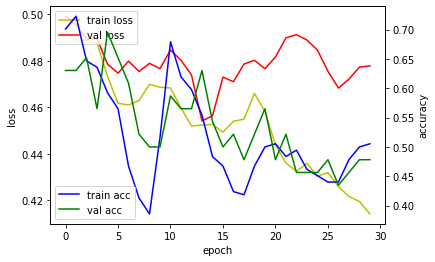

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

# Train / val loss, Train / val acc 그래프 그려보기
fig, loss_aixs = plt.subplots()

acc_aixs = loss_aixs.twinx()

loss_aixs.plot(train_loss_list, 'y', label='train loss')
loss_aixs.plot(val_loss_list, 'r', label='val loss')

acc_aixs.plot(train_accuracy_list, 'b', label='train acc')
acc_aixs.plot(val_accuracy_list, 'g', label='val acc')

loss_aixs.set_xlabel('epoch')
loss_aixs.set_ylabel('loss')
acc_aixs.set_ylabel('accuracy')

loss_aixs.legend(loc='upper left')
acc_aixs.legend(loc='lower left')

plt.show()

## Model Evaluation

In [55]:
# Train Dataset에 대한 모델의 Loss와 Accuracy 값 리턴
model.evaluate(train_x, train_y)

184/184 [==============================] - 0s 92us/sample - loss: 0.0722 - acc: 0.9511


[0.07223690074423085, 0.95108694]

In [56]:
# Test Dataset에 대한 모델의 Loss와 Accuracy 값 리턴
model.evaluate(test_x, test_y)

46/46 [==============================] - 0s 152us/sample - loss: 0.2913 - acc: 0.7609


[0.2913026213645935, 0.76086956]

In [57]:
# Train Dataset에 대해 모델 예측
train_h = model.predict(train_x)
train_p = (train_h > 0.5).astype(int).flatten()

In [58]:
# Test Dataset에 대해 모델 예측
test_h = model.predict(test_x)
test_p = (test_h > 0.5).astype(int).flatten()

In [59]:
# Train / Test Dataset에 대해 Sensitivity, Specificity 계산하고 출력해보기
tr_sensitivity, tr_specificity = check_correct(train_p, train_y)
ts_sensitivity, ts_specificity = check_correct(test_p, test_y)

In [60]:
tr_sensitivity, tr_specificity

(0.94, 0.9552238805970149)

In [61]:
ts_sensitivity, ts_specificity

(0.5555555555555556, 0.8928571428571429)